In [1]:
!pip install xgboost catboost lightgbm scikit-optimize tensorflow tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 3.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.

In [3]:
#required libraries
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from skopt import BayesSearchCV
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop,  Nadam


#quality of life
tf.random.set_seed(42)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
#load the xls:
ccs= pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls')

In [5]:
ccs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [6]:
new_names = []
column_name = ''

for i in ccs.columns:
  count = 0
  for y in i:
    if y == '(':
      break
    else:
      count +=1
    column_name = i[:count]
  new_names.append(column_name.replace(" ","")) #remove whitespace

ccs.columns = new_names

In [7]:
ccs_final = ccs.rename(columns={'Concretecompressivestrength': 'CompressiveStrength'})

In [8]:
#create true/false dataframe for nulls
missing_data = ccs_final.isnull()

#print null values per column
for column in missing_data.columns.values.tolist():
  if missing_data[column].sum() != 0:
    print(column)
    print (missing_data[column].sum())
    print("")
  else:
    print(column,"has no missing values\n")
#check for non-numbers in our values
for i in ccs_final.columns:
  try:
      ccs_final[i].astype(int)
      print('All values in', i, 'are numbers\n')
  except ValueError:
      print('There are non-integer values in', i)
      print("")

Cement has no missing values

BlastFurnaceSlag has no missing values

FlyAsh has no missing values

Water has no missing values

Superplasticizer has no missing values

CoarseAggregate has no missing values

FineAggregate has no missing values

Age has no missing values

CompressiveStrength has no missing values

All values in Cement are numbers

All values in BlastFurnaceSlag are numbers

All values in FlyAsh are numbers

All values in Water are numbers

All values in Superplasticizer are numbers

All values in CoarseAggregate are numbers

All values in FineAggregate are numbers

All values in Age are numbers

All values in CompressiveStrength are numbers



In [9]:
#removing duplicate values
ccs_final = ccs_final.drop_duplicates(keep='first')
ccs_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1005 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1005 non-null   float64
 1   BlastFurnaceSlag     1005 non-null   float64
 2   FlyAsh               1005 non-null   float64
 3   Water                1005 non-null   float64
 4   Superplasticizer     1005 non-null   float64
 5   CoarseAggregate      1005 non-null   float64
 6   FineAggregate        1005 non-null   float64
 7   Age                  1005 non-null   int64  
 8   CompressiveStrength  1005 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 78.5 KB


Univariate Analysis

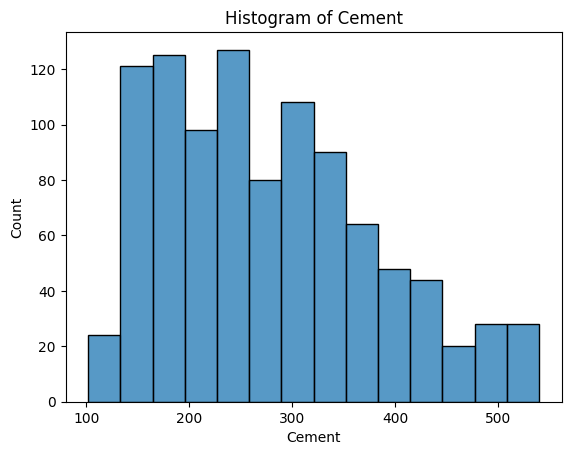

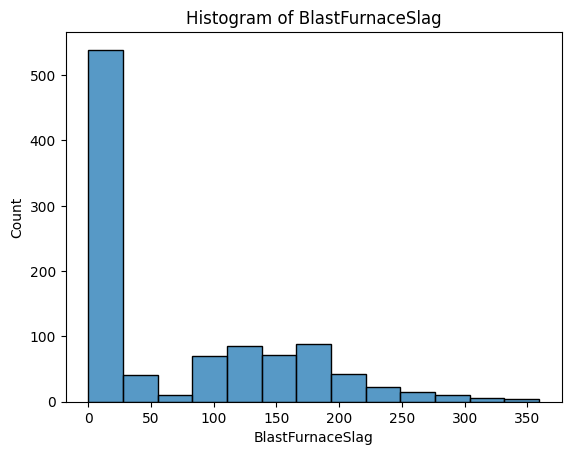

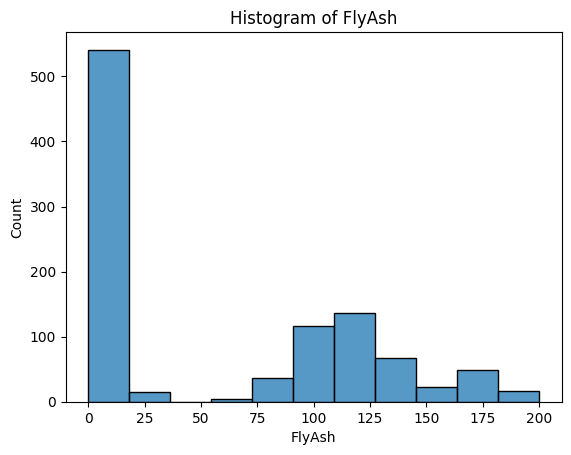

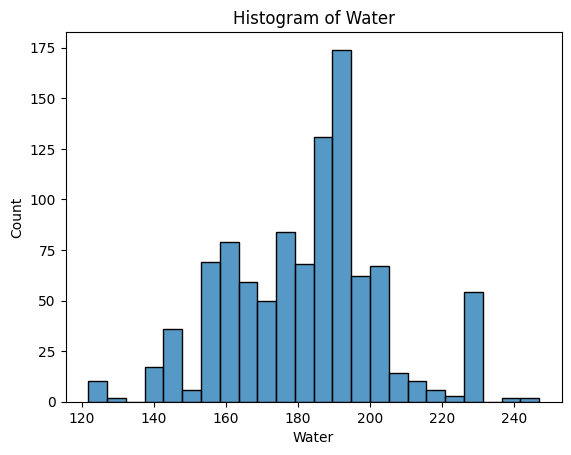

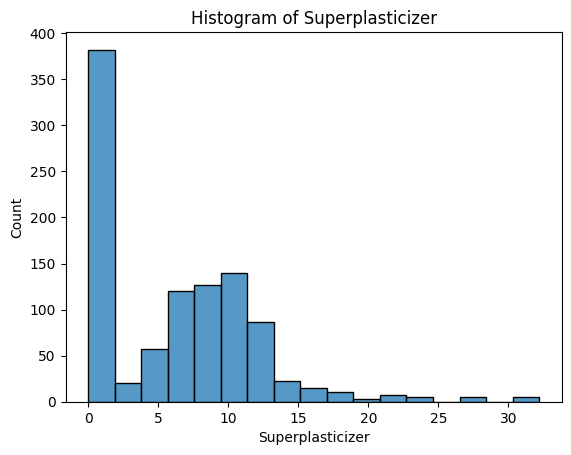

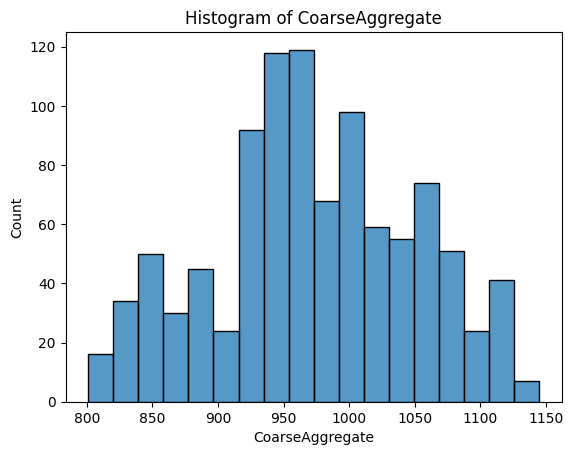

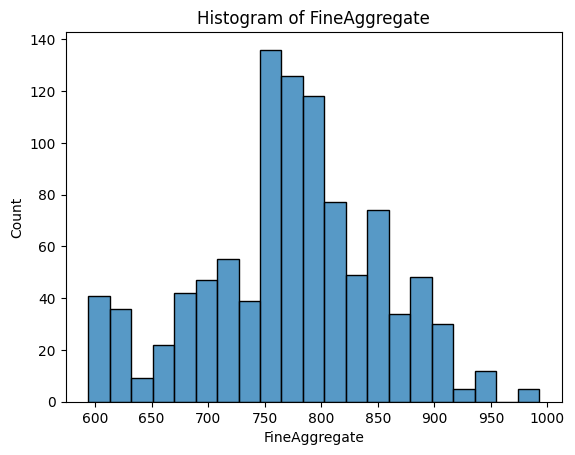

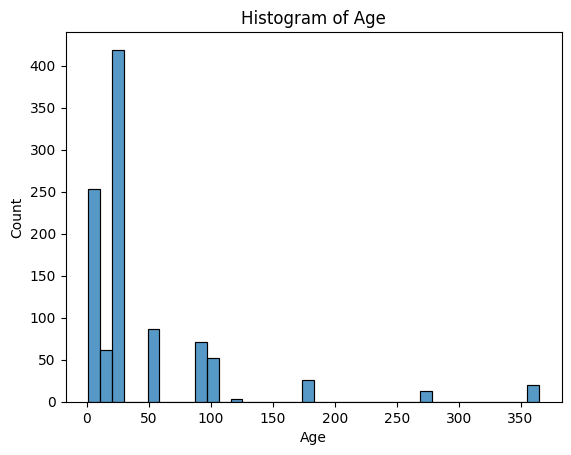

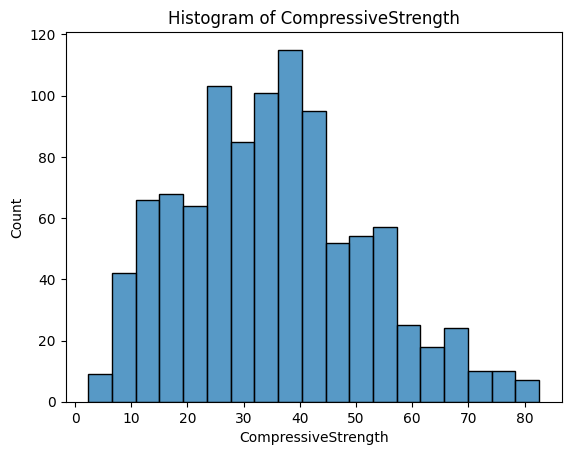

In [10]:
for col in ccs_final.columns:
      plt.figure()
      sns.histplot(data=ccs_final, x=col, multiple="dodge")
      plt.title(f"Histogram of {col}")
      plt.show()

In [11]:
ccs_final['Age'].value_counts()

,count
Age,
28,419
3,129
7,122
56,86
14,62
90,54
100,52
180,26
91,17


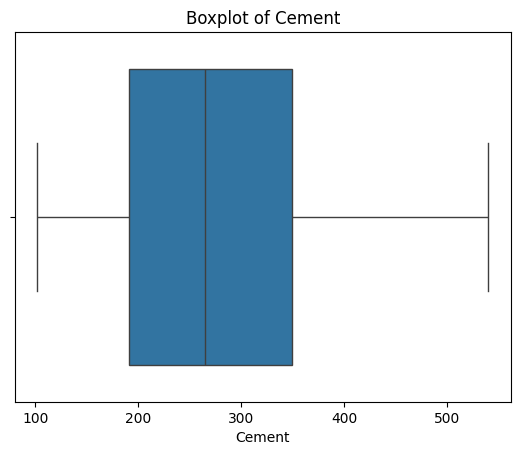

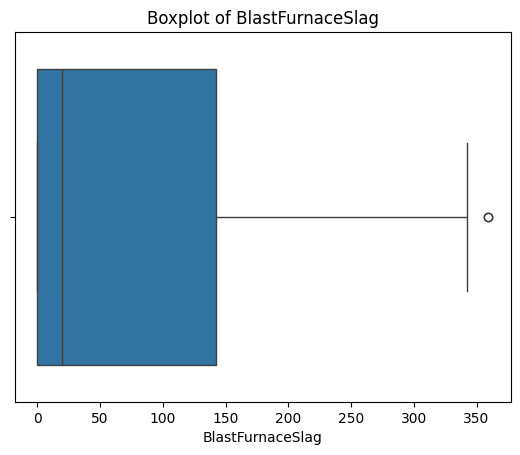

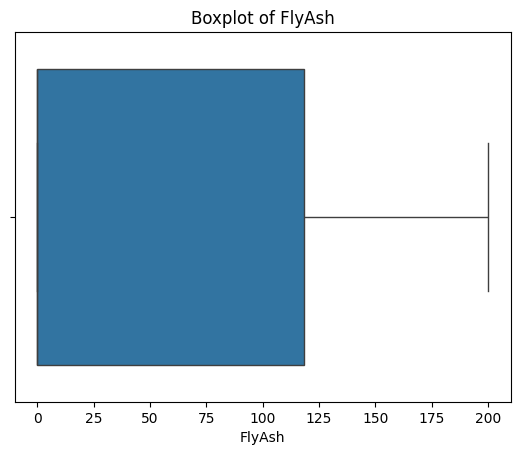

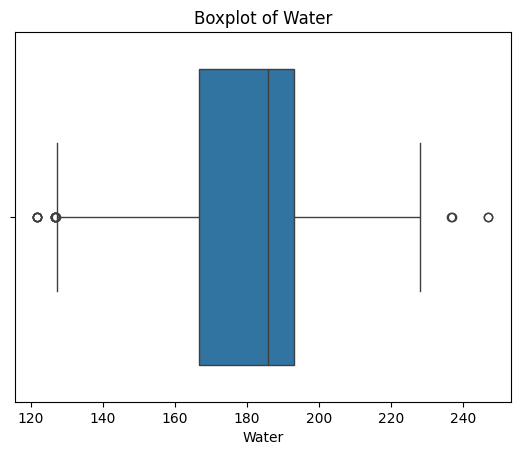

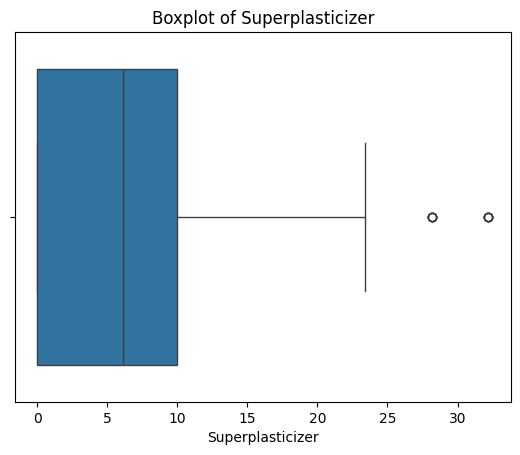

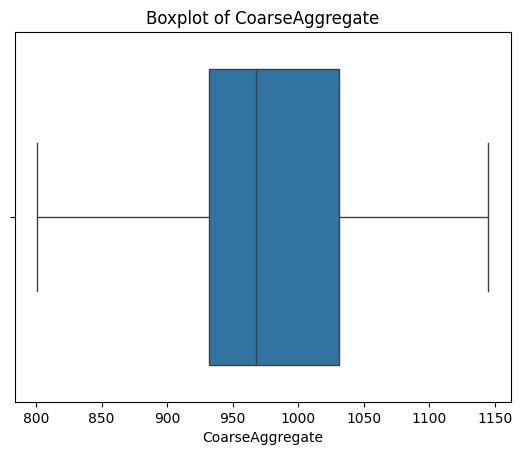

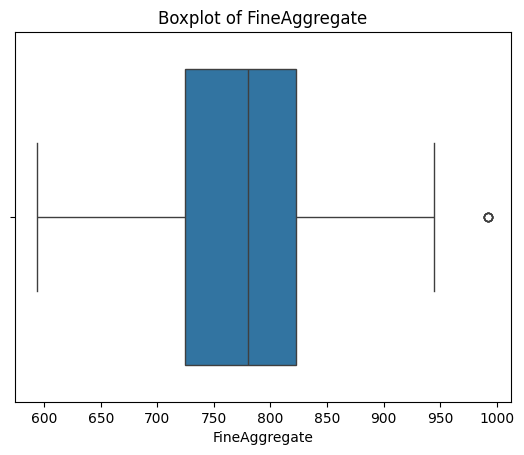

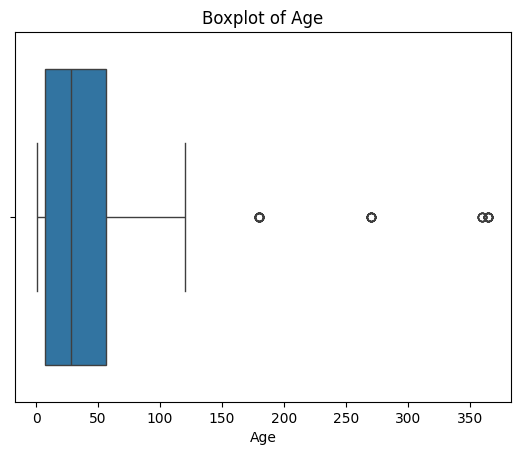

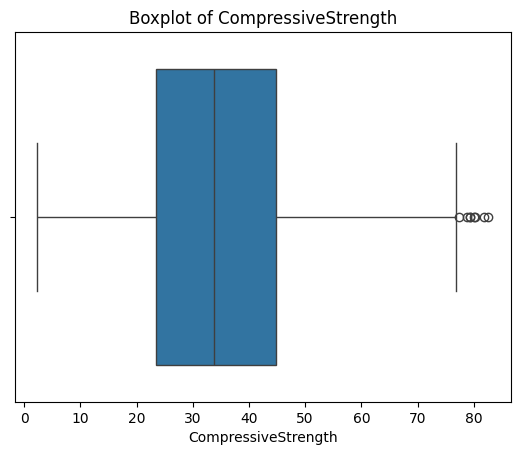

In [12]:
#boxplots univariate
for col in ccs_final.columns:
      plt.figure()
      sns.boxplot(data=ccs_final, x=col)
      plt.title(f"Boxplot of {col}")
      plt.show()

Correlation Matrix

<Axes: >

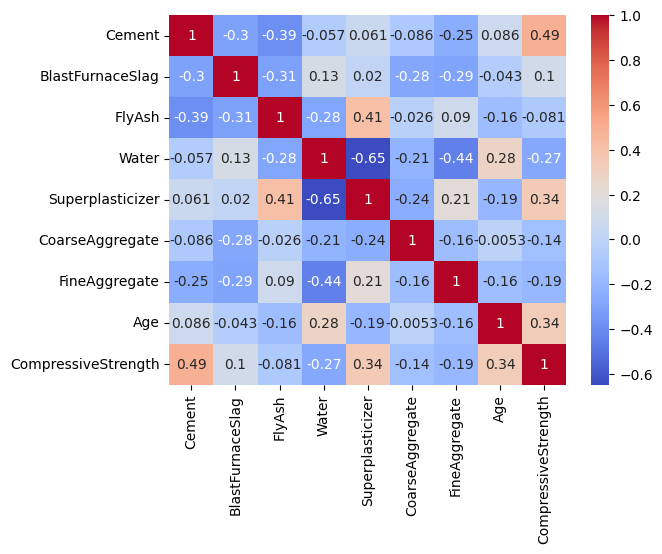

In [13]:
corr = ccs_final.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)

Feature Engineering

In [14]:
#new df w/o outliers
ccs_final_nout= ccs_final[(np.abs(stats.zscore(ccs_final)) <= 3).all(axis=1)]

ccs_final_nout.info()

<class 'pandas.core.frame.DataFrame'>
Index: 956 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               956 non-null    float64
 1   BlastFurnaceSlag     956 non-null    float64
 2   FlyAsh               956 non-null    float64
 3   Water                956 non-null    float64
 4   Superplasticizer     956 non-null    float64
 5   CoarseAggregate      956 non-null    float64
 6   FineAggregate        956 non-null    float64
 7   Age                  956 non-null    int64  
 8   CompressiveStrength  956 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 74.7 KB


In [15]:
#test/train split w/ outliers
X_train_ccs, X_test_ccs, y_train_ccs, y_test_ccs= train_test_split (
    ccs_final.iloc[:,:-1], ccs_final.iloc[:,-1], test_size=0.2,
     random_state=42)

In [16]:
#test/train split w/o outliers
#nout is short for no outliers
X_train_ccs_nout, X_test_ccs_nout, y_train_ccs_nout, y_test_ccs_nout= train_test_split (
    ccs_final_nout.iloc[:,:-1], ccs_final_nout.iloc[:,-1],
     test_size=0.2, random_state=42)

In [17]:
#splitting X and y
X = ccs_final.iloc[:,:-1]
y = ccs_final.iloc[:,-1]

X_nout = ccs_final_nout.iloc[:,:-1]
y_nout = ccs_final_nout.iloc[:,-1]

In [18]:
#standardized
scaler = StandardScaler()

#w/ outliers
X_scaled = scaler.fit_transform(X)
X_train_ccs_scaled, X_test_ccs_scaled, y_train_ccs_scaled, y_test_ccs_scaled= train_test_split (
    X_scaled, y, test_size=0.2, random_state=42)

#w/o outliers
X_nout_scaled = scaler.fit_transform(X_nout)
X_train_ccs_nout_scaled, X_test_ccs_nout_scaled, y_train_ccs_nout_scaled, y_test_ccs_nout_scaled= train_test_split (
    X_nout_scaled, y_nout, test_size=0.2, random_state=42)

In [19]:
#min max scaling
mm_scaler = MinMaxScaler()

#w/ outliers
X_mm_scaled = mm_scaler.fit_transform(X)
X_train_ccs_mm_scaled, X_test_ccs_mm_scaled, y_train_ccs_mm_scaled, y_test_ccs_mm_scaled=train_test_split (
    X_mm_scaled, y, test_size=0.2, random_state=42)

#w/o outliers
X_nout_mm_scaled = mm_scaler.fit_transform(X_nout)
X_train_ccs_nout_mm_scaled, X_test_ccs_nout_mm_scaled, y_train_ccs_nout_mm_scaled, y_test_ccs_nout_mm_scaled= train_test_split (
    X_nout_mm_scaled, y_nout, test_size=0.2, random_state=42)

In [20]:
#normalized
normalizer = Normalizer()

#w/ outliers
X_norm = normalizer.fit_transform(X)
X_train_ccs_norm, X_test_ccs_norm, y_train_ccs_norm, y_test_ccs_norm=train_test_split (
    X_norm, y, test_size=0.2, random_state=42)

#w/o outliers
X_nout_norm = normalizer.fit_transform(X_nout)
X_train_ccs_nout_norm, X_test_ccs_nout_norm, y_train_ccs_nout_norm, y_test_ccs_nout_norm= train_test_split (
    X_nout_norm, y_nout, test_size=0.2, random_state=42)

Combination of Algorithms

LR: -103.416627 (14.309652)
Score for each of the 10 K-fold tests:  [-113.78724053  -91.4670907   -95.21804763 -109.72045779  -76.65148173
 -129.47853791  -92.20856548 -106.56462201 -116.02998812 -103.04024042]
LinearRegression()
	Training time: 0.017s
	Prediction time: 0.059s

Mean Squared Error (MSE): 103.41230674420017
Mean Absolute Error (MAE): 8.090137117379019
Coefficient of Determination (R-squared): 0.5966971392289928

LASSO: -103.474021 (14.074931)
Score for each of the 10 K-fold tests:  [-114.25638424  -91.341341    -95.28062937 -109.92396986  -76.50081693
 -127.49132421  -92.82373893 -107.33415478 -116.7385576  -103.04929675]
Lasso()
	Training time: 0.006s
	Prediction time: 0.058s

Mean Squared Error (MSE): 103.47017340636444
Mean Absolute Error (MAE): 8.093438818510133
Coefficient of Determination (R-squared): 0.5964714621202531

EN: -103.425187 (14.159990)
Score for each of the 10 K-fold tests:  [-114.04872813  -91.40750155  -95.21199618 -109.84491262  -76.47617612
 -128.1

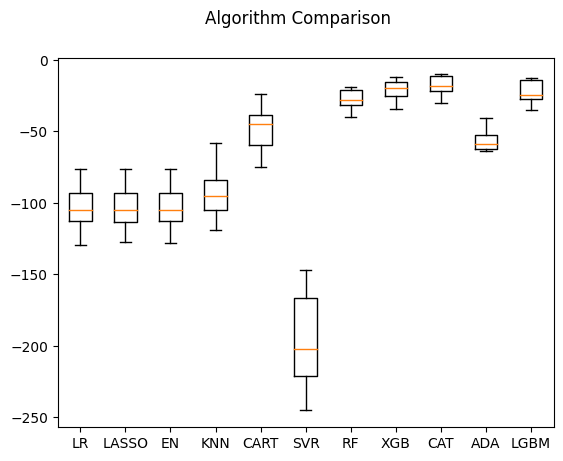

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 723, number of used features: 8
[LightGBM] [Info] Start training from score 34.903261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [ ]:
from itertools import combinations
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from time import time
import matplotlib.pyplot as plt

# Parameters
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scoring = 'neg_mean_squared_error'

# Model list
models = [
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    ('SVR', SVR()),
    ('RF', RandomForestRegressor()),
    ('XGB', XGBRegressor(objective='reg:squarederror')),
    ('CAT', CatBoostRegressor(verbose=0)),
    ('ADA', AdaBoostRegressor()),
    ('LGBM', LGBMRegressor())
]

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    start = time()
    model.fit(X_train_ccs, y_train_ccs)
    train_time = time() - start
    # Standard data w/ outliers for cv
    cv_results = cross_val_score(model, X_train_ccs, y_train_ccs,
                                 cv=kfold, scoring=scoring)
    predict_time = time()-start
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print("Score for each of the 10 K-fold tests: ", cv_results)
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print()

    # Calculate additional metrics: MSE, MAE, R-squared
    y_pred = cross_val_predict(model, X_train_ccs, y_train_ccs, cv=kfold)
    mse = mean_squared_error(y_train_ccs, y_pred)
    mae = mean_absolute_error(y_train_ccs, y_pred)
    r2 = r2_score(y_train_ccs, y_pred)
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("Coefficient of Determination (R-squared):", r2)
    print()

# Boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Store results
combination_results = []

# Loop over combinations of models
for model1, model2 in combinations(models, 2):
    model1_name, model1_instance = model1
    model2_name, model2_instance = model2

    # Create ensemble of the two models
    ensemble_model = VotingRegressor([('model1', model1_instance), ('model2', model2_instance)])

    # Fit ensemble model
    start = time()
    ensemble_model.fit(X_train_ccs, y_train_ccs)
    train_time = time() - start

    # Predict using ensemble model
    start = time()
    y_pred_ensemble = cross_val_predict(ensemble_model, X_train_ccs, y_train_ccs, cv=kfold)
    predict_time = time() - start

    # Calculate mean squared error
    mse_ensemble = mean_squared_error(y_train_ccs, y_pred_ensemble)
    mae_ensemble = mean_absolute_error(y_train_ccs, y_pred_ensemble)
    r2_ensemble = r2_score(y_train_ccs, y_pred_ensemble)

    # Store results
    combination_results.append((model1_name, model2_name, mse_ensemble, mae_ensemble, r2_ensemble, train_time, predict_time))

# Print results for each combination
for model1_name, model2_name, mse, mae, r2, train_time, predict_time in combination_results:
    print("Combination: {} + {}".format(model1_name, model2_name))
    print("Mean Squared Error: ", mse)
    print("Mean Absolute Error: ", mae)
    print("Coefficient of Determination (R-squared): ", r2)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print()


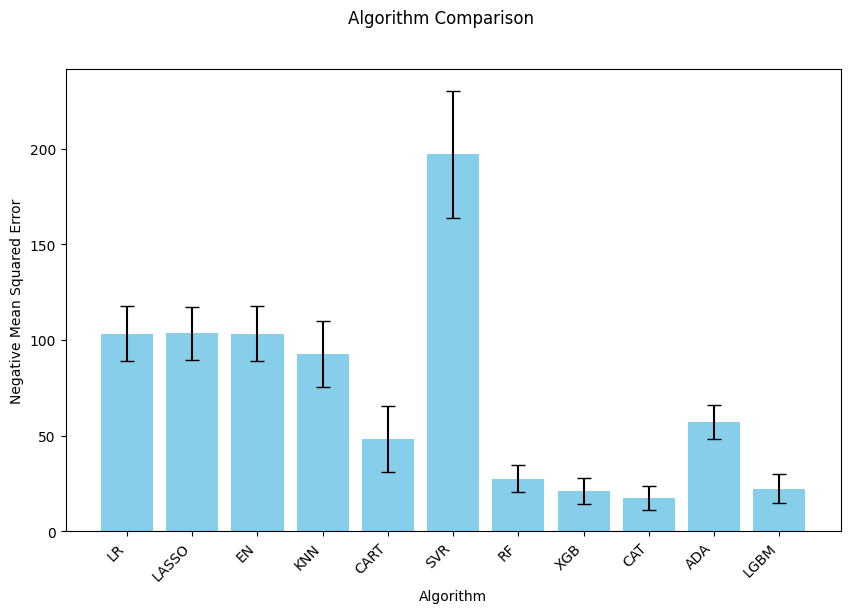

In [ ]:
import numpy as np

# Boxplot algorithm comparison
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Algorithm Comparison')

# Plot bar chart for individual algorithm comparison
ax.bar(names, [-result.mean() for result in results], yerr=[result.std() for result in results], capsize=5, color='skyblue')

ax.set_ylabel('Negative Mean Squared Error')
ax.set_xlabel('Algorithm')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
#assortment of trees
number_of_trees=np.arange(50,501,10)

In [ ]:
#prints number of columns and square root of number of columns
print(X_train_ccs.shape[1])
print(np.sqrt(X_train_ccs_nout.shape[1]))

8
2.8284271247461903


In [ ]:
#create arrangement of possible feature based off columns and columns sq root
number_of_features=np.arange(2,5)

#create an empty numpy array based off trees/feature arrangments
mse_scores_rf_oob_matrix= np.empty((number_of_features.size,
                                    number_of_trees.size))
mse_scores_rf_oob_matrix.shape

(3, 46)

In [ ]:
#essentially a gridsearch but certain parameters are reduced because of existing information
r=0
for i in number_of_features:
  c=0
  for j in number_of_trees:
    rf_loop= RandomForestRegressor(n_estimators = j, oob_score= True,
                                   max_features=i, random_state=42)
    rf_loop.fit(X_train_ccs_nout, y_train_ccs_nout)
    mse_scores_rf_oob_matrix[r,c]= mean_squared_error(y_train_ccs_nout,
                                                      rf_loop.oob_prediction_)
    c=c+1
  r= r+1

In [ ]:
#number of features to use
number_of_features[np.where(mse_scores_rf_oob_matrix == np.min(
    mse_scores_rf_oob_matrix))[0]]

array([4])

In [ ]:
#ensemble of trees to use
number_of_trees[np.where(
    mse_scores_rf_oob_matrix == np.min(mse_scores_rf_oob_matrix))[1]]

array([130])

In [ ]:
#create parameters
search_space_rf = {
    'n_estimators': (10, 500, 20),
    'max_features': (2, 8),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 10)
}

In [ ]:
#bayesian optimization using parameters previously defined
kfold = KFold(n_splits=10, random_state=42, shuffle=True)

bayes_rf_tuner = BayesSearchCV(estimator=RandomForestRegressor(random_state=42),
                               search_spaces=search_space_rf, n_iter=32,
                               cv=kfold,
                               verbose=2,n_jobs=-1,scoring=scoring,
                               random_state=42)

In [ ]:
#fit training data uisng CV to bayesion tuner
bayes_rf_tuner.fit(X_train_ccs_nout, y_train_ccs_nout)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

BayesSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
              estimator=RandomForestRegressor(random_state=42), n_iter=32,
              n_jobs=-1, random_state=42, scoring='neg_mean_squared_error',
              search_spaces={'max_features': (2, 8),
                             'min_samples_leaf': (1, 10),
                             'min_samples_split': (2, 10),
                             'n_estimators': (10, 500, 20)},
              verbose=2)

In [ ]:
#things to change
max_layers = 5
output_layer = Dense(1)
input_shape = (X_train_ccs_nout_mm_scaled.shape[1],)

In [ ]:
#function to build search parameters
def build_search_space():

    #simple to do params section
    search_space = {'lr': np.arange(.001, .0501, .0001),
                    'layers': np.arange(1, max_layers+1),
                    'batch_size': [16, 32, 64, 128],
                    'optimizers': [RMSprop, Adam, Nadam]
                    #SGD causes the exploding gradient problem in regression
                   }


    #adds to search_space with the number of layers desired
    for i in range(1, max_layers+1):
        search_space.update({'n_units'+str(i): np.arange(64, 513, 64)
                            })
        search_space.update({'kernel'+str(i): ('glorot_normal', 'he_normal',
                                               'he_uniform', 'glorot_uniform')
                            })
        search_space.update({'active'+str(i): ('relu', 'tanh', 'sigmoid')
                            })
        search_space.update({'dropout'+str(i): np.arange(0.0, 0.8, 0.1)
                            })
        search_space.update({'normalizer'+str(i): [0, 1]
                            })

    return search_space

In [ ]:
#function to model
#input params require adjusting based off the number of layers
#i've placed 5 as the default
#any more than 5 would require adding another variable per param
def build_nn_model(lr,
                   layers,
                   batch_size,
                   optimizers,
                   active1,active2,active3,active4,active5,
                   n_units1,n_units2,n_units3,n_units4,n_units5,
                   kernel1,kernel2,kernel3,kernel4,kernel5,
                   dropout1,dropout2,dropout3,dropout4,dropout5,
                   normalizer1,normalizer2,normalizer3,normalizer4,normalizer5,
                  ):

    model = Sequential()

    #layers as a search param allows us to alternate all the sizes of our model
    for i in range(1, layers):
        #input layer
        if i == 1:
            model.add(Dense(eval(f"n_units{i}"), activation=eval(f"active{i}"),
                            kernel_initializer=eval(f"kernel{i}"),
                            input_shape=input_shape,
                            name = 'dense_layer'+str(i)))

        #hidden layers
        else:
            model.add(Dense(eval(f"n_units{i}"), activation=eval(f"active{i}"),
                            kernel_initializer=eval(f"kernel{i}"),
                            name = 'dense_layer'+str(i)))

        #regularization
        model.add(Dropout(eval(f"dropout{i}")))

        if eval(f"normalizer{i}") == 1:
          model.add(BatchNormalization())

    #add output layer
    model.add(output_layer)

    model.compile(optimizer=optimizers(learning_rate=lr), loss='mse')

    return model

In [ ]:
!pip install tensorflow

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Load the trained models (assuming you have already trained them)
catboost_model = CatBoostRegressor()  # Assuming you have trained the CatBoost model
xgboost_model = XGBRegressor()  # Assuming you have trained the XGBoost model

# Function to predict concrete compressive strength using ensemble model
def predict_concrete_compressive_strength(cement, slag, fly_ash, water, superplasticizer, coarse_aggregate, fine_aggregate, age):
    # Prepare input data
    input_data = np.array([[cement, slag, fly_ash, water, superplasticizer, coarse_aggregate, fine_aggregate, age]])

    # Scale input data (assuming you have used StandardScaler during training)
    input_data_scaled = mm_scaler.transform(input_data)

    # Create ensemble model with CatBoost and XGBoost
    ensemble_model = VotingRegressor([('catboost', catboost_model), ('xgboost', xgboost_model)])

    # Fit the ensemble model
    ensemble_model.fit(X_train_ccs_nout_mm_scaled, y_train_ccs_nout_mm_scaled)  # Assuming you have X_train and y_train

    # Predict compressive strength
    prediction = ensemble_model.predict(input_data_scaled)
    return prediction[0]

# Main function
def main():
    # Get user input for concrete mixture parameters
    cement = float(input("Enter the quantity of Cement (kg/m3): "))
    slag = float(input("Enter the quantity of Blast Furnace Slag (kg/m3): "))
    fly_ash = float(input("Enter the quantity of Fly Ash (kg/m3): "))
    water = float(input("Enter the quantity of Water (kg/m3): "))
    superplasticizer = float(input("Enter the quantity of Superplasticizer (kg/m3): "))
    coarse_aggregate = float(input("Enter the quantity of Coarse Aggregate (kg/m3): "))
    fine_aggregate = float(input("Enter the quantity of Fine Aggregate (kg/m3): "))
    age = float(input("Enter the age of the concrete (days): "))

    # Predict compressive strength
    predicted_strength = predict_concrete_compressive_strength(cement, slag, fly_ash, water, superplasticizer, coarse_aggregate, fine_aggregate, age)
    print("Predicted compressive strength of concrete:", predicted_strength)

if __name__ == "__main__":
    main()
